In [348]:
import os # Interacts with operating systems
from glob import glob # Return all file paths that match a specific pattern

from tqdm import tqdm # Shows progress bar
import cv2 # Computer Vision library
import numpy as np # Support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions
import pandas as pd # Support for data manipulation and analysis
import random
from itertools import groupby 

import plotly.express as px # Graphing library
import plotly.graph_objects as go 

import torch # Used for CNN in general
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn # CNN neural network

from catboost import CatBoostRegressor # CNN package 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import lightgbm as lgb # LGBM package

from sklearn.preprocessing import StandardScaler # ANN package
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout



In [241]:
main_path = "C:/Users/skmoon/Desktop/open"
train_imgs = glob(main_path+"/train/*/*/*.png") + glob(main_path+"/train/*/*/*.jpg")
train_imgs = sorted(train_imgs)
test_imgs = glob(main_path+"/test/image/*.png") + glob(main_path+"/test/image/*.jpg")
test_imgs = sorted(test_imgs)
train_data = glob(main_path+"/train/*/meta/*.csv")
train_label = glob(main_path+"/train/*/*.csv")
test_data = glob(main_path+"/test/meta/*.csv")
preprocessing_train_imgs = "C:/Users/skmoon/Desktop/open/PREPROCESSING-TRAIN"
preprocessing_test_imgs = "C:/Users/skmoon/Desktop/open/PREPROCESSING-TEST"
if not os.path.exists(preprocessing_train_imgs):
    os.mkdir(preprocessing_train_imgs)
if not os.path.exists(preprocessing_test_imgs):
    os.mkdir(preprocessing_test_imgs)

In [224]:
def automatic_brightness_and_contrast(image, clip_hist_percent=0.025):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

In [149]:

def get_image_data(dir_in, dir_out):
    ratio_list = []

    for i in tqdm(dir_in):
        name = i.split("\\")[-1]
        img = cv2.imread(i, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(615,462))
        brightscale, alpha, beta = automatic_brightness_and_contrast(img)
        imgcopy = brightscale.copy()
        hsvimage = cv2.cvtColor(brightscale, cv2.COLOR_BGR2HSV)
        lower = np.array([22,40,0])
        upper = np.array([85,255,245])
        mask = cv2.inRange(hsvimage, lower, upper)
        number_of_white_pix = np.sum(mask == 255)
        number_of_black_pix = np.sum(mask == 0)
        ratio = number_of_white_pix / (number_of_white_pix + number_of_black_pix)
        ratio_list.append(ratio)
        result = cv2.bitwise_and(imgcopy, imgcopy, mask=mask)
        cv2.imwrite(os.path.join(dir_out,name), result)
    
    return ratio_list

ratio_train = get_image_data(train_imgs, preprocessing_train_imgs)
ratio_test = get_image_data(test_imgs, preprocessing_test_imgs)

processed_train_imgs = glob(main_path+"/PREPROCESSING-TRAIN/*.png") + glob(main_path+"/PREPROCESSING-TRAIN/*.jpg")
processed_train_imgs = sorted(processed_train_imgs)

processed_test_imgs = glob(main_path+"/PREPROCESSING-TEST/*.png") + glob(main_path+"/PREPROCESSING-TEST/*.jpg")
processed_test_imgs = sorted(processed_test_imgs)

100%|██████████| 460/460 [01:33<00:00,  4.92it/s]


In [368]:
# Train data with mean unit

train_df = []
for i in tqdm(train_data):
    name = i.split("\\")[-1].split(".")[0]
    df = pd.read_csv(i)
    df = df.drop('시간', axis = 1)
    case = name.split("_")[0]
    label = pd.read_csv(f"C:/Users/skmoon/Desktop/open/train/{case}/label.csv")
    label_name = [i.split(".")[0] for i in label.img_name]
    label.img_name = label_name
    leaf_weight = label[label.img_name == name].leaf_weight.values[0]
    df["무게"] = leaf_weight
    # df["화이트 LED동작강도"] = df["화이트 LED동작강도"].fillna(method='bfill', limit=1)
    # df["화이트 LED동작강도"] = df["화이트 LED동작강도"].fillna(method='ffill', limit=1)
    # df["레드 LED동작강도"] = df["레드 LED동작강도"].fillna(method='bfill', limit=1)
    # df["레드 LED동작강도"] = df["레드 LED동작강도"].fillna(method='ffill', limit=1)
    # df["블루 LED동작강도"] = df["블루 LED동작강도"].fillna(method='bfill', limit=1)
    # df["블루 LED동작강도"] = df["블루 LED동작강도"].fillna(method='ffill', limit=1)
    # df["최근분무량"] = df["최근분무량"].fillna(method='bfill', limit=1)
    # df["최근분무량"] = df["최근분무량"].fillna(method='ffill', limit=1)
    # df = df.interpolate()
    water = df['최근분무량'].round(2).tolist()
    if np.mean(water) > 1000:
        nums = [list(v) for k,v in groupby(water, key = lambda x: x != 0) if k != 0]
        if len(nums) == 2:
            cumulative = nums[0][-1] - nums[0][0] + nums[1][-1]
        else:
            cumulative = nums[0][-1] - nums[0][0]
            
    elif 1000 > np.mean(water) > 0:
        nums = [key for key, _group in groupby(water)]
        cumulative = sum(nums[1:])
    else:
        cumulative = 0

    print(cumulative, i)

    df = df.fillna(0)
    '''
    정량이 정해져 있음 bbfill, ffill (LED, 분무량)
    정량이 정해져 있지 않음 interpolate (그외)
    '''
    df = df.mean()
    df = df.to_frame().T
    df["이미지"] = name
    df['최근분무량'] = cumulative

    train_df.append(df)

train_df = pd.concat(train_df, ignore_index=True)
train_df['비율'] = ratio_train
train_df.head()

  1%|          | 10/1592 [00:00<00:34, 45.87it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE01\meta\CASE01_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE01\meta\CASE01_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE01\meta\CASE01_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE01\meta\CASE01_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE01\meta\CASE01_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE01\meta\CASE01_06.csv
0 C:/Users/skmoon/Desktop/open/train\CASE01\meta\CASE01_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE01\meta\CASE01_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE01\meta\CASE01_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE02\meta\CASE02_01.csv


  1%|▏         | 22/1592 [00:00<00:30, 51.87it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE02\meta\CASE02_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE02\meta\CASE02_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE02\meta\CASE02_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE02\meta\CASE02_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE02\meta\CASE02_06.csv
0 C:/Users/skmoon/Desktop/open/train\CASE02\meta\CASE02_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE02\meta\CASE02_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE02\meta\CASE02_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE02\meta\CASE02_10.csv
0 C:/Users/skmoon/Desktop/open/train\CASE02\meta\CASE02_11.csv
2061.15 C:/Users/skmoon/Desktop/open/train\CASE03\meta\CASE03_01.csv
938.6399999999999 C:/Users/skmoon/Desktop/open/train\CASE03\meta\CASE03_02.csv


  2%|▏         | 28/1592 [00:00<00:30, 51.79it/s]

1686.98 C:/Users/skmoon/Desktop/open/train\CASE03\meta\CASE03_03.csv
2061.15 C:/Users/skmoon/Desktop/open/train\CASE03\meta\CASE03_04.csv
2993.3600000000006 C:/Users/skmoon/Desktop/open/train\CASE03\meta\CASE03_05.csv
1312.8100000000002 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_01.csv
1503.1100000000001 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_02.csv
1312.81 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_03.csv
1838.6999999999998 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_04.csv
1083.93 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_05.csv
2061.1500000000005 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_06.csv
1870.8500000000001 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_07.csv
1306.38 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_08.csv


  3%|▎         | 40/1592 [00:00<00:30, 51.48it/s]

1503.1100000000001 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_09.csv
748.3399999999999 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_10.csv
2061.15 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_11.csv
-642616.7999999999 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_12.csv
-642565.3599999999 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_13.csv
2245.0200000000004 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_14.csv
0 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_15.csv
2029.0 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_16.csv
2061.15 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_17.csv
-642558.9299999999 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_18.csv
2054.7200000000003 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_19.csv


  3%|▎         | 52/1592 [00:01<00:29, 52.11it/s]

2390.3100000000004 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_20.csv
2954.7800000000007 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_21.csv
1686.98 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_22.csv
1451.67 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_23.csv
2061.1500000000005 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_24.csv
2535.6000000000004 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_25.csv
2061.15 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_26.csv
-642610.3699999999 C:/Users/skmoon/Desktop/open/train\CASE04\meta\CASE04_27.csv
0 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_01.csv
1353.85 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_02.csv
698.1299999999999 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_03.csv
862.71 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_04.csv


  4%|▍         | 64/1592 [00:01<00:29, 52.03it/s]

1353.85 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_05.csv
610.71 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_06.csv
743.14 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_07.csv
1108.28 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_08.csv
491.14 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_09.csv
943.7 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_10.csv
1347.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_11.csv
2058.41 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_12.csv
862.71 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_13.csv
1473.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_14.csv
1473.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_15.csv


  5%|▍         | 76/1592 [00:01<00:29, 51.40it/s]

1263.83 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_16.csv
1353.85 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_17.csv
1108.28 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_18.csv
1227.85 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_19.csv
988.71 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_20.csv
1599.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_21.csv
126.0 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_22.csv
0 C:/Users/skmoon/Desktop/open/train\CASE05\meta\CASE05_23.csv
6356.39 C:/Users/skmoon/Desktop/open/train\CASE06\meta\CASE06_01.csv
6248.3099999999995 C:/Users/skmoon/Desktop/open/train\CASE06\meta\CASE06_02.csv
6862.99 C:/Users/skmoon/Desktop/open/train\CASE06\meta\CASE06_03.csv
8343.12 C:/Users/skmoon/Desktop/open/train\CASE06\meta\CASE06_04.csv


  6%|▌         | 88/1592 [00:01<00:28, 52.31it/s]

9121.150000000001 C:/Users/skmoon/Desktop/open/train\CASE06\meta\CASE06_05.csv
8920.59 C:/Users/skmoon/Desktop/open/train\CASE06\meta\CASE06_06.csv
9428.56 C:/Users/skmoon/Desktop/open/train\CASE06\meta\CASE06_07.csv
10339.02 C:/Users/skmoon/Desktop/open/train\CASE06\meta\CASE06_08.csv
9341.14 C:/Users/skmoon/Desktop/open/train\CASE06\meta\CASE06_09.csv
2874.07 C:/Users/skmoon/Desktop/open/train\CASE06\meta\CASE06_10.csv
7094.469999999999 C:/Users/skmoon/Desktop/open/train\CASE06\meta\CASE06_11.csv
6762.709999999999 C:/Users/skmoon/Desktop/open/train\CASE07\meta\CASE07_01.csv
6401.399999999999 C:/Users/skmoon/Desktop/open/train\CASE07\meta\CASE07_02.csv
9651.01 C:/Users/skmoon/Desktop/open/train\CASE07\meta\CASE07_03.csv
9972.510000000002 C:/Users/skmoon/Desktop/open/train\CASE07\meta\CASE07_04.csv


  6%|▋         | 102/1592 [00:01<00:26, 57.16it/s]

9171.359999999999 C:/Users/skmoon/Desktop/open/train\CASE07\meta\CASE07_05.csv
8628.64 C:/Users/skmoon/Desktop/open/train\CASE07\meta\CASE07_06.csv
8310.97 C:/Users/skmoon/Desktop/open/train\CASE07\meta\CASE07_07.csv
10004.66 C:/Users/skmoon/Desktop/open/train\CASE07\meta\CASE07_08.csv
9010.61 C:/Users/skmoon/Desktop/open/train\CASE07\meta\CASE07_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE08\meta\CASE08_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE08\meta\CASE08_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE08\meta\CASE08_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE08\meta\CASE08_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE08\meta\CASE08_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE08\meta\CASE08_06.csv
0 C:/Users/skmoon/Desktop/open/train\CASE08\meta\CASE08_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE08\meta\CASE08_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE08\meta\CASE08_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE08\meta\CASE08_10.csv


  7%|▋         | 117/1592 [00:02<00:22, 65.00it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE08\meta\CASE08_11.csv
0 C:/Users/skmoon/Desktop/open/train\CASE09\meta\CASE09_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE09\meta\CASE09_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE09\meta\CASE09_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE09\meta\CASE09_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE09\meta\CASE09_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE09\meta\CASE09_06.csv
0 C:/Users/skmoon/Desktop/open/train\CASE09\meta\CASE09_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE09\meta\CASE09_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE09\meta\CASE09_09.csv
12246.13 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_01.csv
13027.990000000002 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_02.csv
11515.71 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_03.csv
9964.850000000002 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_04.csv
9984.14 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_05.csv


  8%|▊         | 131/1592 [00:02<00:24, 60.12it/s]

13790.56 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_06.csv
13829.14 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_07.csv
9208.71 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_08.csv
9189.420000000002 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_09.csv
12297.57 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_10.csv
11168.49 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_11.csv
13822.71 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_12.csv
12291.14 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_13.csv
12982.98 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_14.csv
10290.18 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_15.csv
12278.279999999999 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_16.csv
10380.2 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_17.csv
10727.42 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_18.csv


  9%|▉         | 144/1592 [00:02<00:25, 55.80it/s]

9582.880000000001 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_19.csv
9971.279999999999 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_20.csv
12655.05 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_21.csv
11509.28 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_22.csv
12239.7 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_23.csv
11943.92 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_24.csv
0 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_25.csv
11515.71 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_26.csv
12258.990000000002 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_27.csv
12655.050000000001 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_28.csv
12271.85 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_29.csv


  9%|▉         | 150/1592 [00:02<00:27, 52.25it/s]

10746.71 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_30.csv
9546.9 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_31.csv
12262.82 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_32.csv
10746.710000000001 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_33.csv
13481.92 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_34.csv
11693.15 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_35.csv
10393.06 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_36.csv
10452.16 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_37.csv
11213.5 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_38.csv
10701.699999999999 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_39.csv


 10%|█         | 162/1592 [00:03<00:28, 50.02it/s]

9971.28 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_40.csv
12667.91 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_41.csv
12021.08 C:/Users/skmoon/Desktop/open/train\CASE10\meta\CASE10_42.csv
12239.7 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_01.csv
13040.85 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_02.csv
10733.85 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_03.csv
11515.710000000001 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_04.csv
8439.71 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_05.csv
14565.99 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_06.csv
13053.71 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_07.csv
9971.28 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_08.csv


 11%|█         | 174/1592 [00:03<00:27, 50.95it/s]

9971.28 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_09.csv
11522.14 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_10.csv
11162.06 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_11.csv
13835.57 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_12.csv
12284.71 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_13.csv
12976.55 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_14.csv
9527.61 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_15.csv
11136.34 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_16.csv
10746.71 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_17.csv
11123.480000000001 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_18.csv
9193.25 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_19.csv


 12%|█▏        | 186/1592 [00:03<00:28, 49.65it/s]

9208.710000000001 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_20.csv
13411.19 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_21.csv
11515.710000000001 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_22.csv
13008.699999999999 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_23.csv
9643.35 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_24.csv
0 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_25.csv
10746.710000000001 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_26.csv
11879.62 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_27.csv
13047.28 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_28.csv
12258.99 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_29.csv


 12%|█▏        | 191/1592 [00:03<00:29, 47.21it/s]

9221.57 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_30.csv
9923.67 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_31.csv
12648.62 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_32.csv
11522.14 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_33.csv
11892.48 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_34.csv
10975.59 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_35.csv
11931.06 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_36.csv
9683.16 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_37.csv
11976.07 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_38.csv


 13%|█▎        | 201/1592 [00:03<00:30, 46.36it/s]

9932.7 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_39.csv
10746.71 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_40.csv
12436.43 C:/Users/skmoon/Desktop/open/train\CASE11\meta\CASE11_41.csv
13816.279999999999 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_01.csv
12278.279999999999 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_02.csv
9951.990000000002 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_03.csv
11528.57 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_04.csv
9964.849999999999 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_05.csv
13816.279999999999 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_06.csv


 13%|█▎        | 211/1592 [00:04<00:32, 42.38it/s]

12271.849999999999 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_07.csv
10746.710000000001 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_08.csv
9208.710000000001 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_09.csv
11982.5 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_10.csv
12233.269999999999 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_11.csv
13073.0 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_12.csv
12271.849999999999 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_13.csv
12213.98 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_14.csv


 14%|█▍        | 222/1592 [00:04<00:29, 46.75it/s]

9534.04 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_15.csv
12667.91 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_16.csv
11522.14 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_17.csv
9579.050000000001 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_18.csv
9962.249999999998 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_19.csv
10354.480000000001 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_20.csv
13040.85 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_21.csv
11477.130000000001 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_22.csv
12745.07 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_23.csv
0 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_24.csv
11515.71 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_25.csv
10740.28 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_26.csv


 15%|█▍        | 233/1592 [00:04<00:29, 46.05it/s]

11886.050000000001 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_27.csv
13816.28 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_28.csv
11483.56 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_29.csv
8459.0 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_30.csv
11455.24 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_31.csv
12655.050000000001 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_32.csv
12284.71 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_33.csv
12520.02 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_34.csv
11117.05 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_35.csv


 15%|█▌        | 243/1592 [00:04<00:30, 44.33it/s]

10769.83 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_36.csv
9299.96 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_37.csv
12751.5 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_38.csv
8401.130000000001 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_39.csv
11886.05 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_40.csv
12796.509999999998 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_41.csv
0 C:/Users/skmoon/Desktop/open/train\CASE12\meta\CASE12_42.csv
13803.42 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_01.csv
12291.14 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_02.csv
8413.990000000002 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_03.csv


 16%|█▌        | 248/1592 [00:04<00:31, 42.87it/s]

12297.57 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_04.csv
10727.42 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_05.csv
13816.279999999999 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_06.csv
12278.279999999999 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_07.csv
9202.28 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_08.csv
10753.14 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_09.csv
11937.49 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_10.csv
12278.279999999999 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_11.csv
13066.57 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_12.csv


 16%|█▋        | 259/1592 [00:05<00:30, 43.88it/s]

12271.849999999999 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_13.csv
11444.98 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_14.csv
10303.04 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_15.csv
12674.34 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_16.csv
11515.71 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_17.csv
8803.619999999999 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_18.csv
9968.68 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_19.csv
11123.48 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_20.csv
12278.28 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_21.csv


 17%|█▋        | 269/1592 [00:05<00:30, 43.62it/s]

11470.7 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_22.csv
12751.5 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_23.csv
0 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_24.csv
11509.279999999999 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_25.csv
11509.28 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_26.csv
11879.62 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_27.csv
13816.28 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_28.csv
11496.419999999998 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_29.csv
8446.14 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_30.csv
11468.1 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_31.csv


 18%|█▊        | 279/1592 [00:05<00:29, 43.94it/s]

11886.050000000001 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_32.csv
13047.279999999999 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_33.csv
12513.59 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_34.csv
10763.400000000001 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_35.csv
11129.91 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_36.csv
9293.529999999999 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_37.csv
11950.35 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_38.csv
8439.710000000001 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_39.csv
11892.48 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_40.csv
12796.509999999998 C:/Users/skmoon/Desktop/open/train\CASE13\meta\CASE13_41.csv


 18%|█▊        | 291/1592 [00:05<00:27, 47.82it/s]

14565.990000000002 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_01.csv
11522.14 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_02.csv
9189.420000000002 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_03.csv
10753.140000000001 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_04.csv
12252.559999999998 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_05.csv
13829.14 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_06.csv
10746.71 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_07.csv
8426.85 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_08.csv
13060.14 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_09.csv
9636.92 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_10.csv


 19%|█▉        | 301/1592 [00:06<00:28, 45.97it/s]

13816.279999999999 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_11.csv
13829.14 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_12.csv
12226.84 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_13.csv
10283.75 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_14.csv
11509.279999999999 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_15.csv
11142.77 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_16.csv
11502.85 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_17.csv
9576.45 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_18.csv
8439.71 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_19.csv
11879.619999999999 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_20.csv


 19%|█▉        | 307/1592 [00:06<00:26, 48.05it/s]

11515.710000000003 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_21.csv
13008.7 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_22.csv
11937.49 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_23.csv
0 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_24.csv
11515.71 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_25.csv
11502.85 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_26.csv
12642.190000000002 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_27.csv
13040.85 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_28.csv
10746.71 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_29.csv
9553.33 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_30.csv


 20%|█▉        | 317/1592 [00:06<00:27, 46.98it/s]

11500.25 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_31.csv
11502.850000000002 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_32.csv
13488.349999999999 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_33.csv
10917.72 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_34.csv
11162.06 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_35.csv
10371.17 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_36.csv
11294.49 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_37.csv
10701.699999999999 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_38.csv
9202.280000000002 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_39.csv


 21%|██        | 327/1592 [00:06<00:27, 45.82it/s]

12667.91 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_40.csv
12790.08 C:/Users/skmoon/Desktop/open/train\CASE14\meta\CASE14_41.csv
5516.66 C:/Users/skmoon/Desktop/open/train\CASE15\meta\CASE15_01.csv
5334.0199999999995 C:/Users/skmoon/Desktop/open/train\CASE15\meta\CASE15_02.csv
6850.129999999999 C:/Users/skmoon/Desktop/open/train\CASE15\meta\CASE15_03.csv
7747.7300000000005 C:/Users/skmoon/Desktop/open/train\CASE15\meta\CASE15_04.csv
8863.95 C:/Users/skmoon/Desktop/open/train\CASE15\meta\CASE15_05.csv
9594.369999999999 C:/Users/skmoon/Desktop/open/train\CASE15\meta\CASE15_06.csv
9625.29 C:/Users/skmoon/Desktop/open/train\CASE15\meta\CASE15_07.csv
10551.21 C:/Users/skmoon/Desktop/open/train\CASE15\meta\CASE15_08.csv


 21%|██        | 337/1592 [00:06<00:27, 45.81it/s]

5664.55 C:/Users/skmoon/Desktop/open/train\CASE15\meta\CASE15_09.csv
5591.22 C:/Users/skmoon/Desktop/open/train\CASE15\meta\CASE15_10.csv
9967.31 C:/Users/skmoon/Desktop/open/train\CASE15\meta\CASE15_11.csv
8308.37 C:/Users/skmoon/Desktop/open/train\CASE16\meta\CASE16_01.csv
8533.56 C:/Users/skmoon/Desktop/open/train\CASE16\meta\CASE16_02.csv
11030.86 C:/Users/skmoon/Desktop/open/train\CASE16\meta\CASE16_03.csv
7974.15 C:/Users/skmoon/Desktop/open/train\CASE16\meta\CASE16_04.csv
9063.279999999999 C:/Users/skmoon/Desktop/open/train\CASE17\meta\CASE17_01.csv
8026.82 C:/Users/skmoon/Desktop/open/train\CASE17\meta\CASE17_02.csv
8032.0199999999995 C:/Users/skmoon/Desktop/open/train\CASE17\meta\CASE17_03.csv


 21%|██▏       | 342/1592 [00:06<00:27, 45.68it/s]

9074.91 C:/Users/skmoon/Desktop/open/train\CASE18\meta\CASE18_01.csv
10992.28 C:/Users/skmoon/Desktop/open/train\CASE18\meta\CASE18_02.csv
10628.37 C:/Users/skmoon/Desktop/open/train\CASE18\meta\CASE18_03.csv
9602.17 C:/Users/skmoon/Desktop/open/train\CASE18\meta\CASE18_04.csv
8439.570000000002 C:/Users/skmoon/Desktop/open/train\CASE18\meta\CASE18_05.csv
6879.680000000001 C:/Users/skmoon/Desktop/open/train\CASE18\meta\CASE18_06.csv


 22%|██▏       | 352/1592 [00:07<00:30, 40.18it/s]

9088.999999999998 C:/Users/skmoon/Desktop/open/train\CASE18\meta\CASE18_07.csv
10092.079999999998 C:/Users/skmoon/Desktop/open/train\CASE18\meta\CASE18_08.csv
10683.640000000001 C:/Users/skmoon/Desktop/open/train\CASE18\meta\CASE18_09.csv
9953.219999999998 C:/Users/skmoon/Desktop/open/train\CASE18\meta\CASE18_10.csv
6707.44 C:/Users/skmoon/Desktop/open/train\CASE18\meta\CASE18_11.csv
7075.18 C:/Users/skmoon/Desktop/open/train\CASE19\meta\CASE19_01.csv
10295.24 C:/Users/skmoon/Desktop/open/train\CASE19\meta\CASE19_02.csv
7257.8200000000015 C:/Users/skmoon/Desktop/open/train\CASE19\meta\CASE19_03.csv
9248.52 C:/Users/skmoon/Desktop/open/train\CASE19\meta\CASE19_04.csv
8650.53 C:/Users/skmoon/Desktop/open/train\CASE19\meta\CASE19_05.csv


 23%|██▎       | 362/1592 [00:07<00:28, 43.36it/s]

8685.28 C:/Users/skmoon/Desktop/open/train\CASE20\meta\CASE20_01.csv
8872.979999999998 C:/Users/skmoon/Desktop/open/train\CASE20\meta\CASE20_02.csv
9229.23 C:/Users/skmoon/Desktop/open/train\CASE20\meta\CASE20_03.csv
8439.57 C:/Users/skmoon/Desktop/open/train\CASE20\meta\CASE20_04.csv
9145.64 C:/Users/skmoon/Desktop/open/train\CASE20\meta\CASE20_05.csv
6843.7 C:/Users/skmoon/Desktop/open/train\CASE20\meta\CASE20_06.csv
4869.83 C:/Users/skmoon/Desktop/open/train\CASE20\meta\CASE20_07.csv
8703.2 C:/Users/skmoon/Desktop/open/train\CASE20\meta\CASE20_08.csv
8972.03 C:/Users/skmoon/Desktop/open/train\CASE20\meta\CASE20_09.csv
7607.640000000001 C:/Users/skmoon/Desktop/open/train\CASE20\meta\CASE20_10.csv
6659.83 C:/Users/skmoon/Desktop/open/train\CASE20\meta\CASE20_11.csv


 23%|██▎       | 374/1592 [00:07<00:24, 49.15it/s]

10349.279999999999 C:/Users/skmoon/Desktop/open/train\CASE20\meta\CASE20_12.csv
7617.9 C:/Users/skmoon/Desktop/open/train\CASE21\meta\CASE21_01.csv
8943.710000000001 C:/Users/skmoon/Desktop/open/train\CASE21\meta\CASE21_02.csv
9040.16 C:/Users/skmoon/Desktop/open/train\CASE21\meta\CASE21_03.csv
4067.45 C:/Users/skmoon/Desktop/open/train\CASE21\meta\CASE21_04.csv
6810.32 C:/Users/skmoon/Desktop/open/train\CASE21\meta\CASE21_05.csv
8998.980000000001 C:/Users/skmoon/Desktop/open/train\CASE21\meta\CASE21_06.csv
8194.0 C:/Users/skmoon/Desktop/open/train\CASE21\meta\CASE21_07.csv
6649.570000000001 C:/Users/skmoon/Desktop/open/train\CASE21\meta\CASE21_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE22\meta\CASE22_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE22\meta\CASE22_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE22\meta\CASE22_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE22\meta\CASE22_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE22\meta\CASE22_05.csv
0 C:/Users/skmoon/Desktop

 25%|██▌       | 400/1592 [00:07<00:16, 70.26it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE22\meta\CASE22_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE22\meta\CASE22_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE22\meta\CASE22_10.csv
0 C:/Users/skmoon/Desktop/open/train\CASE22\meta\CASE22_11.csv
0 C:/Users/skmoon/Desktop/open/train\CASE23\meta\CASE23_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE23\meta\CASE23_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE23\meta\CASE23_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE23\meta\CASE23_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE23\meta\CASE23_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE23\meta\CASE23_06.csv
0 C:/Users/skmoon/Desktop/open/train\CASE23\meta\CASE23_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE23\meta\CASE23_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE23\meta\CASE23_09.csv
1870.8500000000001 C:/Users/skmoon/Desktop/open/train\CASE24\meta\CASE24_01.csv
2619.1900000000005 C:/Users/skmoon/Desktop/open/train\CASE24\meta\CASE24_02.csv
1464.5299999999997 C:

 26%|██▌       | 408/1592 [00:08<00:18, 65.58it/s]

2619.1900000000005 C:/Users/skmoon/Desktop/open/train\CASE24\meta\CASE24_05.csv
2061.15 C:/Users/skmoon/Desktop/open/train\CASE24\meta\CASE24_06.csv
1312.81 C:/Users/skmoon/Desktop/open/train\CASE24\meta\CASE24_07.csv
1877.2800000000002 C:/Users/skmoon/Desktop/open/train\CASE24\meta\CASE24_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE24\meta\CASE24_09.csv
2428.8900000000003 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_01.csv
2580.6100000000006 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_02.csv
1077.5 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_03.csv
1306.38 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_04.csv
2206.44 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_05.csv
2954.7800000000007 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_06.csv
2212.87 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_07.csv


 27%|██▋       | 422/1592 [00:08<00:20, 57.27it/s]

2580.61 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_08.csv
1686.9800000000002 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_09.csv
1122.5100000000002 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_10.csv
0 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_11.csv
2803.0600000000004 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_12.csv
2167.8600000000006 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_13.csv
1825.8399999999997 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_14.csv
1503.1100000000001 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_15.csv
1686.98 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_16.csv
0 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_17.csv


 28%|██▊       | 439/1592 [00:08<00:16, 67.97it/s]

1774.3999999999999 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_18.csv
938.6399999999999 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_19.csv
1870.8500000000001 C:/Users/skmoon/Desktop/open/train\CASE25\meta\CASE25_20.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_06.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_10.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_11.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_12.csv
0 C:/

 28%|██▊       | 447/1592 [00:08<00:16, 69.98it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_15.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_16.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_17.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_18.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_19.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_20.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_21.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_22.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_23.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_24.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_25.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_26.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_27.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_28.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_29.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26

 29%|██▉       | 464/1592 [00:08<00:14, 75.99it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_31.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_32.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_33.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_34.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_35.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_36.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_37.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_38.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_39.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_40.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_41.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_42.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_43.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_44.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26_45.csv
0 C:/Users/skmoon/Desktop/open/train\CASE26\meta\CASE26

 30%|███       | 481/1592 [00:09<00:17, 65.31it/s]

9967.31 C:/Users/skmoon/Desktop/open/train\CASE27\meta\CASE27_01.csv
7261.65 C:/Users/skmoon/Desktop/open/train\CASE27\meta\CASE27_02.csv
9014.44 C:/Users/skmoon/Desktop/open/train\CASE27\meta\CASE27_03.csv
7405.709999999999 C:/Users/skmoon/Desktop/open/train\CASE27\meta\CASE27_04.csv
11131.140000000001 C:/Users/skmoon/Desktop/open/train\CASE27\meta\CASE27_05.csv
8017.79 C:/Users/skmoon/Desktop/open/train\CASE28\meta\CASE28_01.csv
6809.089999999999 C:/Users/skmoon/Desktop/open/train\CASE28\meta\CASE28_02.csv
10465.020000000002 C:/Users/skmoon/Desktop/open/train\CASE28\meta\CASE28_03.csv
8725.090000000002 C:/Users/skmoon/Desktop/open/train\CASE28\meta\CASE28_04.csv
8723.86 C:/Users/skmoon/Desktop/open/train\CASE28\meta\CASE28_05.csv
5262.0599999999995 C:/Users/skmoon/Desktop/open/train\CASE28\meta\CASE28_06.csv


 31%|███       | 488/1592 [00:09<00:17, 61.71it/s]

10623.17 C:/Users/skmoon/Desktop/open/train\CASE28\meta\CASE28_07.csv
5593.82 C:/Users/skmoon/Desktop/open/train\CASE28\meta\CASE28_08.csv
8159.250000000001 C:/Users/skmoon/Desktop/open/train\CASE28\meta\CASE28_09.csv
10278.550000000001 C:/Users/skmoon/Desktop/open/train\CASE28\meta\CASE28_10.csv
9158.5 C:/Users/skmoon/Desktop/open/train\CASE29\meta\CASE29_01.csv
7221.84 C:/Users/skmoon/Desktop/open/train\CASE29\meta\CASE29_02.csv
5046.040000000001 C:/Users/skmoon/Desktop/open/train\CASE29\meta\CASE29_03.csv
8462.829999999998 C:/Users/skmoon/Desktop/open/train\CASE29\meta\CASE29_04.csv
8440.939999999999 C:/Users/skmoon/Desktop/open/train\CASE29\meta\CASE29_05.csv
8692.94 C:/Users/skmoon/Desktop/open/train\CASE29\meta\CASE29_06.csv
10645.060000000001 C:/Users/skmoon/Desktop/open/train\CASE29\meta\CASE29_07.csv


 32%|███▏      | 512/1592 [00:09<00:15, 68.41it/s]

7765.789999999999 C:/Users/skmoon/Desktop/open/train\CASE29\meta\CASE29_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE30\meta\CASE30_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE30\meta\CASE30_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE30\meta\CASE30_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE30\meta\CASE30_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE30\meta\CASE30_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE30\meta\CASE30_06.csv
0 C:/Users/skmoon/Desktop/open/train\CASE30\meta\CASE30_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE30\meta\CASE30_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE30\meta\CASE30_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE30\meta\CASE30_10.csv
0 C:/Users/skmoon/Desktop/open/train\CASE30\meta\CASE30_11.csv
0 C:/Users/skmoon/Desktop/open/train\CASE31\meta\CASE31_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE31\meta\CASE31_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE31\meta\CASE31_03.csv
0 C:/Users/skmoon/Desktop/open/train\CA

 33%|███▎      | 520/1592 [00:09<00:15, 68.09it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE31\meta\CASE31_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE31\meta\CASE31_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE31\meta\CASE31_09.csv
3069.57 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_01.csv
5325.13 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_02.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_03.csv
8797.19 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_04.csv
8375.41 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_06.csv
2294.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_07.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_08.csv
6811.6900000000005 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_09.csv
5363.710000000001 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_10.csv


 34%|███▎      | 534/1592 [00:10<00:17, 59.01it/s]

2300.57 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_11.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_12.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_13.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_14.csv
4511.12 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_15.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_16.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_17.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_18.csv
2294.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_19.csv
4601.14 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_20.csv
1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_21.csv


 34%|███▍      | 541/1592 [00:10<00:18, 56.87it/s]

4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_22.csv
4556.13 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_23.csv
4601.14 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_24.csv
3774.2700000000004 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_25.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE32\meta\CASE32_26.csv
3793.56 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_01.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_02.csv
4594.71 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_03.csv
8752.179999999998 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_04.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_06.csv


 35%|███▍      | 553/1592 [00:10<00:19, 53.93it/s]

3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_07.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_08.csv
8343.259999999998 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_09.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_10.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_11.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_12.csv
8426.849999999999 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_13.csv
3018.13 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_14.csv
3024.5600000000004 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_15.csv


 35%|███▌      | 564/1592 [00:10<00:21, 46.97it/s]

4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_16.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_17.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_18.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_19.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_20.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_21.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_22.csv
5325.13 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_23.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_24.csv


 36%|███▌      | 576/1592 [00:10<00:20, 50.29it/s]

6837.41 C:/Users/skmoon/Desktop/open/train\CASE33\meta\CASE33_25.csv
0 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_02.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_03.csv
2690.2000000000003 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_04.csv
4598.54 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_05.csv
9195.85 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_06.csv
4977.91 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_07.csv
4144.610000000001 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_08.csv
4984.34 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_09.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_10.csv
5052.469999999999 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_11.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_12.csv


 37%|███▋      | 589/1592 [00:11<00:19, 52.69it/s]

4260.35 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_13.csv
1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_14.csv
7462.349999999999 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_15.csv
2670.91 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_16.csv
6509.48 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_17.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_18.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_19.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_20.csv
6805.259999999999 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_21.csv
3848.83 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_22.csv
1190.78 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_23.csv


 37%|███▋      | 595/1592 [00:11<00:18, 53.75it/s]

1538.0 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_24.csv
3491.3500000000004 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_25.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_26.csv
1538.0 C:/Users/skmoon/Desktop/open/train\CASE34\meta\CASE34_27.csv
0 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_01.csv
4601.14 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_02.csv
3452.7700000000004 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_03.csv
3452.77 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_04.csv
8047.48 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_05.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_06.csv
2683.77 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_07.csv


 39%|███▊      | 613/1592 [00:11<00:17, 56.32it/s]

5676.18 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_08.csv
3452.77 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_09.csv
2715.92 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_10.csv
3105.55 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_11.csv
2728.78 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_12.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_13.csv
7021.28 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_14.csv
3874.55 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_15.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_16.csv
4977.91 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_17.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_18.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_19.csv
4511.12 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_20.csv


 39%|███▉      | 619/1592 [00:11<00:18, 52.65it/s]

4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_21.csv
2317.26 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_22.csv
1959.78 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_23.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_24.csv
1959.78 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_25.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_26.csv
3024.56 C:/Users/skmoon/Desktop/open/train\CASE35\meta\CASE35_27.csv
8124.639999999999 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_01.csv
3799.9900000000002 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_02.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_03.csv


 40%|███▉      | 631/1592 [00:11<00:18, 52.77it/s]

1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_04.csv
2017.65 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_05.csv
5746.91 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_06.csv
6503.050000000001 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_07.csv
5856.22 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_08.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_09.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_10.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_11.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_12.csv
6856.7 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_13.csv
1921.2 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_14.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_15.csv


 40%|████      | 643/1592 [00:12<00:17, 54.22it/s]

5746.91 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_16.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_17.csv
0 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_18.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_19.csv
4273.210000000001 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_20.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_21.csv
3018.13 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_22.csv
2017.65 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_23.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_24.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_25.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_26.csv
2255.56 C:/Users/skmoon/Desktop/open/train\CASE36\meta\CASE36_27.csv


 41%|████      | 655/1592 [00:12<00:18, 49.89it/s]

7625.700000000001 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_01.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_02.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_03.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_04.csv
4694.99 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_05.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_06.csv
6509.48 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_07.csv
2024.08 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_08.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_09.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_10.csv


 42%|████▏     | 666/1592 [00:12<00:20, 45.96it/s]

2300.57 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_11.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_12.csv
6477.33 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_13.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_14.csv
5746.91 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_15.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_16.csv
0 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_17.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_18.csv
5035.780000000001 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_19.csv


 43%|████▎     | 678/1592 [00:12<00:18, 50.10it/s]

5363.71 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_20.csv
1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_21.csv
3504.21 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_22.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_23.csv
1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_24.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_25.csv
3069.57 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_26.csv
3742.12 C:/Users/skmoon/Desktop/open/train\CASE37\meta\CASE37_27.csv
7651.42 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_01.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_02.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_03.csv
5357.280000000001 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_04.csv


 43%|████▎     | 684/1592 [00:13<00:18, 49.11it/s]

4601.14 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_05.csv
4556.13 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_06.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_07.csv
3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_08.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_10.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_11.csv
9572.619999999999 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_12.csv
6081.27 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_13.csv
6081.27 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_14.csv


 44%|████▎     | 695/1592 [00:13<00:18, 49.15it/s]

5363.71 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_15.csv
4208.91 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_16.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_17.csv
6126.28 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_18.csv
4568.99 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_19.csv
6548.06 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_20.csv
6477.33 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_21.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_22.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_23.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_24.csv
3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_25.csv
3793.56 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_26.csv


 44%|████▍     | 707/1592 [00:13<00:17, 51.90it/s]

5363.71 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_27.csv
3459.2000000000003 C:/Users/skmoon/Desktop/open/train\CASE38\meta\CASE38_28.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_01.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_02.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_03.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_04.csv
6087.700000000001 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_05.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_06.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_07.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_08.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_10.csv


 45%|████▌     | 719/1592 [00:13<00:18, 48.46it/s]

7657.85 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_11.csv
8758.609999999999 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_12.csv
6081.2699999999995 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_13.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_14.csv
4977.91 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_15.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_16.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_17.csv
5331.56 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_18.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_19.csv
5016.49 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_20.csv


 46%|████▌     | 731/1592 [00:13<00:16, 50.67it/s]

5714.76 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_21.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_22.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_23.csv
3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_24.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_25.csv
6087.7 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_26.csv
5759.77 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_27.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE39\meta\CASE39_28.csv
0 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_02.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_03.csv
3835.9700000000003 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_04.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_05.csv


 47%|████▋     | 744/1592 [00:14<00:16, 52.99it/s]

1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_06.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_07.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_08.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_09.csv
1921.2 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_10.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_11.csv
0 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_12.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_13.csv
6515.91 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_14.csv
1940.49 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_15.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_16.csv


 47%|████▋     | 756/1592 [00:14<00:15, 52.52it/s]

3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_17.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_18.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_19.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_20.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_21.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_22.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_23.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_24.csv
5286.55 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_25.csv
4549.700000000001 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_26.csv
5312.27 C:/Users/skmoon/Desktop/open/train\CASE40\meta\CASE40_27.csv
0 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_01.csv


 48%|████▊     | 768/1592 [00:14<00:15, 52.97it/s]

8388.27 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_02.csv
5373.970000000001 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_03.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_04.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_05.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_06.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_07.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_08.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_09.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_10.csv
0 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_11.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_12.csv
4298.93 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_13.csv


 49%|████▉     | 780/1592 [00:14<00:15, 51.68it/s]

5689.04 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_14.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_15.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_16.csv
1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_17.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_18.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_19.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_20.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_21.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_22.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_23.csv


 49%|████▉     | 786/1592 [00:15<00:15, 52.01it/s]

5318.700000000001 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_24.csv
3030.9900000000002 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_25.csv
7561.4 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_26.csv
1538.0 C:/Users/skmoon/Desktop/open/train\CASE41\meta\CASE41_27.csv
4562.56 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_01.csv
6132.71 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_03.csv
7657.85 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_04.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_05.csv


 50%|█████     | 797/1592 [00:15<00:16, 48.06it/s]

6895.28 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_06.csv
6087.7 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_07.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_08.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_09.csv
4549.700000000001 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_10.csv
3066.9700000000003 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_11.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_12.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_13.csv
3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_14.csv
3069.57 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_15.csv


 51%|█████     | 808/1592 [00:15<00:16, 48.57it/s]

9189.42 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_16.csv
6126.28 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_17.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_18.csv
4556.13 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_19.csv
8047.48 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_20.csv
2690.2 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_21.csv
6888.85 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_22.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_23.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_24.csv
3439.9100000000003 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_25.csv


 51%|█████▏    | 818/1592 [00:15<00:15, 48.43it/s]

3484.92 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_26.csv
4549.700000000001 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_27.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE42\meta\CASE42_28.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_01.csv
6126.28 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_03.csv
4601.14 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_04.csv
6888.85 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_05.csv
6856.7 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_06.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_07.csv


 52%|█████▏    | 829/1592 [00:15<00:15, 49.01it/s]

3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_08.csv
5318.700000000001 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_09.csv
2683.7700000000004 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_10.csv
5746.91 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_11.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_12.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_13.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_14.csv
7657.85 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_15.csv
6895.280000000001 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_16.csv
5357.280000000001 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_17.csv


 52%|█████▏    | 835/1592 [00:16<00:15, 50.21it/s]

2300.57 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_18.csv
6856.699999999999 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_19.csv
5753.34 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_20.csv
4977.91 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_21.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_22.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_23.csv
3439.9100000000003 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_24.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_25.csv
4202.48 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_26.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_27.csv
7664.28 C:/Users/skmoon/Desktop/open/train\CASE43\meta\CASE43_28.csv


 53%|█████▎    | 847/1592 [00:16<00:14, 52.27it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_02.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_04.csv
8008.9 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_05.csv
6149.4 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_06.csv
4208.91 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_07.csv
6856.7 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_08.csv
2690.2000000000003 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_09.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_10.csv
4568.99 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_11.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_12.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_13.csv


 54%|█████▍    | 859/1592 [00:16<00:13, 52.67it/s]

4977.910000000001 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_14.csv
4311.790000000001 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_15.csv
3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_16.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_17.csv
5357.280000000001 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_18.csv
0 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_19.csv
0 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_20.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_21.csv
4556.13 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_22.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_23.csv


 55%|█████▍    | 871/1592 [00:16<00:13, 52.31it/s]

1152.2 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_24.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_25.csv
0 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_26.csv
6625.219999999999 C:/Users/skmoon/Desktop/open/train\CASE44\meta\CASE44_27.csv
0 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_01.csv
4594.71 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_03.csv
6094.129999999999 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_04.csv
8070.599999999999 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_05.csv
4556.13 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_06.csv
5701.9 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_07.csv


 55%|█████▌    | 883/1592 [00:16<00:14, 48.78it/s]

5753.340000000001 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_08.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_09.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_10.csv
6094.13 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_11.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_12.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_13.csv
6226.56 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_14.csv
2294.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_15.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_16.csv
6126.28 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_17.csv
0 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_18.csv


 56%|█████▌    | 893/1592 [00:17<00:14, 49.25it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_19.csv
3069.57 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_20.csv
3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_21.csv
3030.99 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_22.csv
2683.7700000000004 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_23.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_24.csv
0 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_25.csv
6625.219999999999 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_26.csv
2690.2000000000003 C:/Users/skmoon/Desktop/open/train\CASE45\meta\CASE45_27.csv
1473.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_01.csv
1522.2599999999998 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_02.csv
1234.28 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_03.csv


 57%|█████▋    | 905/1592 [00:17<00:12, 52.98it/s]

2352.8199999999997 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_04.csv
1353.85 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_05.csv
1234.28 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_06.csv
1195.7 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_07.csv
1479.85 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_08.csv
698.13 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_09.csv
1680.4099999999999 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_10.csv
1812.84 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_11.csv
1725.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_12.csv
1227.85 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_13.csv
988.71 C:/Users/skmoon/Desktop/open/train\CASE46\meta\CASE46_14.csv


 58%|█████▊    | 917/1592 [00:17<00:12, 53.46it/s]

1925.9799999999998 C:/Users/skmoon/Desktop/open/train\CASE47\meta\CASE47_01.csv
1069.7 C:/Users/skmoon/Desktop/open/train\CASE47\meta\CASE47_02.csv
988.71 C:/Users/skmoon/Desktop/open/train\CASE47\meta\CASE47_03.csv
1189.27 C:/Users/skmoon/Desktop/open/train\CASE47\meta\CASE47_04.csv
1182.84 C:/Users/skmoon/Desktop/open/train\CASE47\meta\CASE47_05.csv
1189.27 C:/Users/skmoon/Desktop/open/train\CASE47\meta\CASE47_06.csv
578.56 C:/Users/skmoon/Desktop/open/train\CASE47\meta\CASE47_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE47\meta\CASE47_08.csv
1189.27 C:/Users/skmoon/Desktop/open/train\CASE47\meta\CASE47_09.csv
1315.2699999999998 C:/Users/skmoon/Desktop/open/train\CASE47\meta\CASE47_10.csv
1434.84 C:/Users/skmoon/Desktop/open/train\CASE47\meta\CASE47_11.csv


 59%|█████▊    | 933/1592 [00:17<00:09, 66.92it/s]

1353.85 C:/Users/skmoon/Desktop/open/train\CASE48\meta\CASE48_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE48\meta\CASE48_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_06.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_10.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_11.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_12.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_13.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\

 60%|█████▉    | 952/1592 [00:18<00:08, 77.51it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_18.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_19.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_20.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_21.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_22.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_23.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_24.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_25.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_26.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_27.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_28.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_29.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_30.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_31.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_32.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49

 61%|██████    | 969/1592 [00:18<00:09, 69.16it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_37.csv
0 C:/Users/skmoon/Desktop/open/train\CASE49\meta\CASE49_38.csv
5357.280000000001 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_01.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_02.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_03.csv
4260.35 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_04.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_05.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_06.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_07.csv
6438.75 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_08.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_10.csv


 61%|██████▏   | 977/1592 [00:18<00:09, 61.76it/s]

3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_11.csv
6126.28 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_12.csv
3069.57 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_13.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_14.csv
4594.71 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_15.csv
3069.57 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_16.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_17.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_18.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_19.csv


 62%|██████▏   | 984/1592 [00:18<00:10, 56.94it/s]

4234.63 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_20.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_21.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_22.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_23.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_24.csv
5357.280000000001 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_25.csv
7657.85 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_26.csv
3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_27.csv
7664.28 C:/Users/skmoon/Desktop/open/train\CASE50\meta\CASE50_28.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_01.csv
6888.85 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_02.csv


 63%|██████▎   | 996/1592 [00:18<00:11, 53.71it/s]

5029.35 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_03.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_04.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_05.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_06.csv
8002.469999999999 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_07.csv
2268.42 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_08.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_10.csv
4594.71 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_11.csv
4601.14 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_12.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_13.csv


 63%|██████▎   | 1008/1592 [00:19<00:10, 54.58it/s]

5363.71 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_14.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_15.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_16.csv
3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_17.csv
6132.71 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_18.csv
5003.63 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_19.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_20.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_21.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_22.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_23.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_24.csv
6119.85 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_25.csv


 64%|██████▍   | 1020/1592 [00:19<00:10, 52.61it/s]

5363.71 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_26.csv
6895.280000000001 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_27.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE51\meta\CASE51_28.csv
0 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_02.csv
8356.119999999999 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_03.csv
1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_04.csv
7642.389999999999 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_06.csv
6503.050000000001 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_07.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_08.csv


 65%|██████▍   | 1032/1592 [00:19<00:11, 48.80it/s]

3024.56 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_09.csv
3459.2000000000003 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_10.csv
3452.7700000000004 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_11.csv
0 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_12.csv
6586.64 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_13.csv
2658.05 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_14.csv
0 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_15.csv
4241.06 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_16.csv
0 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_17.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_18.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_19.csv


 66%|██████▌   | 1044/1592 [00:19<00:10, 50.90it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_20.csv
8475.689999999999 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_21.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_22.csv
3925.9900000000002 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_23.csv
3446.34 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_24.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_25.csv
4343.9400000000005 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_26.csv
3459.2000000000003 C:/Users/skmoon/Desktop/open/train\CASE52\meta\CASE52_27.csv
0 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_01.csv
7587.12 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_02.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_03.csv


 66%|██████▌   | 1050/1592 [00:19<00:11, 48.74it/s]

5348.25 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_05.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_06.csv
5740.48 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_07.csv
3024.5600000000004 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_08.csv
3459.2000000000003 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_09.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_10.csv
0 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_11.csv
6895.280000000001 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_12.csv


 67%|██████▋   | 1061/1592 [00:20<00:11, 47.87it/s]

6175.12 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_13.csv
0 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_14.csv
3099.1200000000003 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_15.csv
0 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_16.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_17.csv
5357.280000000001 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_18.csv
0 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_19.csv
5830.5 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_20.csv
6477.33 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_21.csv
2394.42 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_22.csv


 67%|██████▋   | 1073/1592 [00:20<00:10, 50.12it/s]

4208.91 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_23.csv
1538.0 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_24.csv
4388.950000000001 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_25.csv
3414.19 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_26.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE53\meta\CASE53_27.csv
6863.13 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_01.csv
4594.71 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_02.csv
6126.28 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_03.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_04.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_05.csv
4594.71 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_06.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_07.csv


 68%|██████▊   | 1085/1592 [00:20<00:10, 50.55it/s]

8388.27 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_08.csv
5325.130000000001 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_09.csv
4601.14 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_10.csv
2294.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_11.csv
4594.71 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_12.csv
4601.14 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_13.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_14.csv
8028.19 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_15.csv
8111.78 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_16.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_17.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_18.csv


 69%|██████▉   | 1097/1592 [00:20<00:09, 50.75it/s]

2300.57 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_19.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_20.csv
3472.0600000000004 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_21.csv
6119.85 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_22.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_23.csv
6132.71 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_24.csv
5350.85 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_25.csv
4594.71 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_26.csv
4601.14 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_27.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE54\meta\CASE54_28.csv


 69%|██████▉   | 1103/1592 [00:20<00:09, 50.28it/s]

3799.9900000000002 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_01.csv
8420.42 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_02.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_03.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_04.csv
6126.28 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_05.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_06.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_07.csv
6850.2699999999995 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_08.csv
5331.56 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_09.csv


 70%|██████▉   | 1114/1592 [00:21<00:10, 45.97it/s]

3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_10.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_11.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_12.csv
3069.57 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_13.csv
7259.19 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_14.csv
6132.71 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_15.csv
7342.78 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_16.csv
6895.280000000001 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_17.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_18.csv


 71%|███████   | 1124/1592 [00:21<00:10, 45.42it/s]

4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_19.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_20.csv
5766.2 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_21.csv
4594.71 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_22.csv
6132.71 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_23.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_24.csv
4588.280000000001 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_25.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_26.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_27.csv


 71%|███████   | 1134/1592 [00:21<00:10, 45.23it/s]

5312.27 C:/Users/skmoon/Desktop/open/train\CASE55\meta\CASE55_28.csv
0 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_02.csv
8420.42 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_03.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_04.csv
5325.13 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_05.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_06.csv
5357.280000000001 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_07.csv
4247.49 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_08.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_09.csv


 72%|███████▏  | 1144/1592 [00:21<00:09, 46.67it/s]

5363.71 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_10.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_11.csv
5029.35 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_12.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_13.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_14.csv
0 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_15.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_16.csv
4720.71 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_17.csv
6059.38 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_18.csv
3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_19.csv


 72%|███████▏  | 1150/1592 [00:21<00:09, 48.94it/s]

8501.41 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_20.csv
4556.13 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_21.csv
2735.21 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_22.csv
5714.76 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_23.csv
4523.98 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_24.csv
3504.21 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_25.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_26.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE56\meta\CASE56_27.csv
0 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_01.csv
9189.42 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_02.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_03.csv


 73%|███████▎  | 1162/1592 [00:22<00:08, 50.52it/s]

6087.700000000001 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_04.csv
3069.57 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_05.csv
4588.280000000001 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_06.csv
5016.490000000001 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_07.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_08.csv
6126.28 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_09.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_10.csv
7323.490000000001 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_11.csv
1538.0 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_12.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_13.csv
6087.7 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_14.csv


 74%|███████▎  | 1174/1592 [00:22<00:07, 52.66it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_15.csv
2696.63 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_16.csv
8340.66 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_17.csv
5100.08 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_18.csv
4260.35 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_19.csv
7265.619999999999 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_20.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_21.csv
4617.83 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_22.csv
4556.13 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_23.csv
5772.629999999999 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_24.csv
1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_25.csv


 74%|███████▍  | 1186/1592 [00:22<00:07, 51.94it/s]

2300.57 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_26.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE57\meta\CASE57_27.csv
1599.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_01.csv
2090.5599999999995 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_02.csv
1844.9899999999998 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_03.csv
1635.3999999999999 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_04.csv
2216.5599999999995 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_05.csv
1353.85 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_06.csv
1599.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_07.csv
1599.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_08.csv
982.28 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_09.csv


 75%|███████▌  | 1198/1592 [00:22<00:07, 51.94it/s]

1473.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_10.csv
1641.83 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_11.csv
1925.9799999999998 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_12.csv
988.71 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_13.csv
2291.12 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_14.csv
1925.9799999999998 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_15.csv
862.71 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_16.csv
1182.84 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_17.csv
1673.9799999999998 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_18.csv
988.71 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_19.csv
743.14 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_20.csv


 76%|███████▌  | 1209/1592 [00:23<00:07, 48.01it/s]

1473.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_21.csv
1353.85 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_22.csv
856.28 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_23.csv
1599.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_24.csv
1806.4099999999999 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_25.csv
1844.9899999999998 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_26.csv
862.71 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_27.csv
1353.85 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_28.csv
1234.28 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_29.csv
1353.85 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_30.csv


 76%|███████▋  | 1217/1592 [00:23<00:06, 54.91it/s]

1101.85 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_31.csv
1592.9899999999998 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_32.csv
1182.84 C:/Users/skmoon/Desktop/open/train\CASE58\meta\CASE58_33.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_06.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_10.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_11.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_12.csv


 77%|███████▋  | 1233/1592 [00:23<00:05, 65.39it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_13.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_14.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_15.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_16.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_17.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_18.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_19.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_20.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_21.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_22.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_23.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_24.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_25.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_26.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_27.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59

 79%|███████▊  | 1251/1592 [00:23<00:04, 68.67it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_32.csv
0 C:/Users/skmoon/Desktop/open/train\CASE59\meta\CASE59_33.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_01.csv
1473.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_02.csv
1592.9899999999998 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_03.csv
1554.4099999999999 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_04.csv
1560.84 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_05.csv
1844.9899999999998 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_06.csv
1599.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_07.csv
1353.85 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_09.csv


 79%|███████▉  | 1265/1592 [00:23<00:05, 61.29it/s]

1176.4099999999999 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_10.csv
982.28 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_11.csv
1234.28 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_12.csv
817.7 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_13.csv
1353.85 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_14.csv
1964.5599999999997 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_15.csv
491.14 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_16.csv
1101.85 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_17.csv
1063.27 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_18.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_19.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_20.csv


 80%|████████  | 1274/1592 [00:24<00:04, 68.62it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_21.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_22.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_23.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_24.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_25.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_26.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_27.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_28.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_29.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_30.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_31.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_32.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_33.csv
0 C:/Users/skmoon/Desktop/open/train\CASE60\meta\CASE60_34.csv
0 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_01.csv


 81%|████████  | 1289/1592 [00:24<00:04, 62.75it/s]

769.0 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_02.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_03.csv
6126.28 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_04.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_05.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_06.csv
1908.34 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_07.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_08.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_09.csv
6087.7 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_10.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_11.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_12.csv
8426.849999999999 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_13.csv


 82%|████████▏ | 1303/1592 [00:24<00:05, 57.04it/s]

2300.57 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_14.csv
1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_15.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_16.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_17.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_18.csv
5357.280000000001 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_19.csv
4601.14 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_20.csv
4588.28 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_21.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_22.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_23.csv
6856.7 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_24.csv


 82%|████████▏ | 1309/1592 [00:24<00:05, 54.90it/s]

2300.57 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_25.csv
3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_26.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_27.csv
7657.849999999999 C:/Users/skmoon/Desktop/open/train\CASE61\meta\CASE61_28.csv
3787.13 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_01.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_02.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_03.csv
4601.14 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_04.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_05.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_06.csv
6503.049999999999 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_07.csv


 83%|████████▎ | 1321/1592 [00:25<00:06, 43.77it/s]

6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_08.csv
6087.7 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_09.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_10.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_11.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_12.csv
6895.280000000001 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_13.csv
1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_14.csv


 83%|████████▎ | 1326/1592 [00:25<00:06, 43.92it/s]

1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_15.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_16.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_17.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_18.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_19.csv
3825.71 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_20.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_21.csv
6126.28 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_22.csv
9157.27 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_23.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_24.csv


 84%|████████▍ | 1338/1592 [00:25<00:05, 49.47it/s]

3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_25.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_26.csv
6126.28 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_27.csv
4601.14 C:/Users/skmoon/Desktop/open/train\CASE62\meta\CASE62_28.csv
0 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_02.csv
4086.7400000000002 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_03.csv
6515.91 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_04.csv
4604.97 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_05.csv
5357.280000000001 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_06.csv
6168.69 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_07.csv
6132.71 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_08.csv


 85%|████████▍ | 1350/1592 [00:25<00:04, 53.08it/s]

5357.280000000001 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_09.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_10.csv
3452.77 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_11.csv
7239.9 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_12.csv
5318.7 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_13.csv
4363.23 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_14.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_15.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_16.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_17.csv
4253.92 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_18.csv
6895.28 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_19.csv


 86%|████████▌ | 1362/1592 [00:25<00:04, 52.25it/s]

5325.13 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_20.csv
5325.13 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_21.csv
3024.56 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_22.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_23.csv
4965.05 C:/Users/skmoon/Desktop/open/train\CASE63\meta\CASE63_24.csv
0 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_01.csv
7104.87 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_02.csv
2690.2 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_03.csv
8053.910000000001 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_04.csv
4208.91 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_05.csv
6126.280000000001 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_06.csv
5406.12 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_07.csv


 86%|████████▋ | 1374/1592 [00:26<00:04, 53.42it/s]

4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_08.csv
6895.280000000001 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_09.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_10.csv
6136.54 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_11.csv
5273.69 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_12.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_13.csv
4363.23 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_14.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_15.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_16.csv
1525.1399999999999 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_17.csv


 87%|████████▋ | 1386/1592 [00:26<00:04, 49.35it/s]

8092.49 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_18.csv
5325.13 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_19.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_20.csv
5280.12 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_21.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_22.csv
3472.0600000000004 C:/Users/skmoon/Desktop/open/train\CASE64\meta\CASE64_23.csv
3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE65\meta\CASE65_01.csv
5325.13 C:/Users/skmoon/Desktop/open/train\CASE65\meta\CASE65_02.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE66\meta\CASE66_01.csv
6509.4800000000005 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_01.csv


 87%|████████▋ | 1391/1592 [00:26<00:04, 48.70it/s]

769.0 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_03.csv
7657.85 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_04.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_05.csv
6119.85 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_06.csv
6132.71 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_07.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_08.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_09.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_10.csv


 88%|████████▊ | 1401/1592 [00:26<00:04, 44.43it/s]

6094.13 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_11.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_12.csv
7612.84 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_13.csv
7619.2699999999995 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_14.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_15.csv
4549.700000000001 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_16.csv
6087.7 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_17.csv
7619.2699999999995 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_18.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_19.csv


 89%|████████▊ | 1411/1592 [00:26<00:04, 44.31it/s]

5292.9800000000005 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_20.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_21.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_22.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_23.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_24.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_25.csv
1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_26.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_27.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE67\meta\CASE67_28.csv


 89%|████████▉ | 1421/1592 [00:27<00:03, 43.50it/s]

4215.34 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_01.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_03.csv
5357.280000000001 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_04.csv
3825.7100000000005 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_05.csv
8426.85 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_06.csv
1538.0 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_07.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_08.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_09.csv


 90%|████████▉ | 1432/1592 [00:27<00:03, 47.42it/s]

8394.7 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_10.csv
1531.5700000000002 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_11.csv
6081.27 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_12.csv
7657.849999999999 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_13.csv
5325.130000000001 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_14.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_15.csv
3787.13 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_16.csv
8343.259999999998 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_17.csv
4594.710000000001 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_18.csv
5331.56 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_19.csv
2261.99 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_20.csv


 91%|█████████ | 1442/1592 [00:27<00:03, 45.48it/s]

2300.57 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_21.csv
4594.71 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_22.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_23.csv
3832.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_24.csv
3063.1400000000003 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_25.csv
769.0 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_26.csv
2300.57 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_27.csv
5363.71 C:/Users/skmoon/Desktop/open/train\CASE68\meta\CASE68_28.csv
736.71 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_01.csv


 91%|█████████ | 1448/1592 [00:27<00:02, 48.43it/s]

1673.9799999999998 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_02.csv
1599.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_03.csv
1227.85 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_04.csv
1189.27 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_05.csv
1635.3999999999999 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_06.csv
1101.85 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_07.csv
988.71 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_08.csv
1227.85 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_09.csv
856.28 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_10.csv
988.71 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_11.csv
0 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_12.csv


 92%|█████████▏| 1460/1592 [00:27<00:02, 49.93it/s]

371.57 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_13.csv
332.99 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_14.csv
950.13 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_15.csv
824.13 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_16.csv
245.57 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_17.csv
0 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_18.csv
0 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_19.csv
862.71 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_20.csv
736.71 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_21.csv
1328.1299999999999 C:/Users/skmoon/Desktop/open/train\CASE69\meta\CASE69_22.csv
988.71 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_01.csv


 92%|█████████▏| 1472/1592 [00:28<00:02, 51.73it/s]

1227.85 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_02.csv
743.14 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_03.csv
862.71 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_04.csv
1547.9799999999998 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_06.csv
371.57 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_07.csv
1101.85 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_08.csv
824.1299999999999 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_09.csv
956.56 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_10.csv
1182.84 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_11.csv
0 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_12.csv
1389.83 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_13.csv


 93%|█████████▎| 1485/1592 [00:28<00:01, 56.40it/s]

988.71 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_14.csv
617.14 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_15.csv
578.56 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_16.csv
1069.7 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_17.csv
0 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_18.csv
0 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_19.csv
0 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_20.csv
0 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_21.csv
0 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_22.csv
0 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_23.csv
0 C:/Users/skmoon/Desktop/open/train\CASE70\meta\CASE70_24.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_03.csv


 94%|█████████▍| 1500/1592 [00:28<00:01, 63.29it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_06.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_10.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_11.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_12.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_13.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_14.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_15.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_16.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_17.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_18.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71

 95%|█████████▌| 1516/1592 [00:28<00:01, 68.30it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_20.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_21.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_22.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_23.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_24.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_25.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_26.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_27.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_28.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_29.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_30.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_31.csv
0 C:/Users/skmoon/Desktop/open/train\CASE71\meta\CASE71_32.csv
0 C:/Users/skmoon/Desktop/open/train\CASE72\meta\CASE72_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE72\meta\CASE72_02.csv


 96%|█████████▌| 1532/1592 [00:28<00:00, 69.27it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE72\meta\CASE72_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE72\meta\CASE72_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE72\meta\CASE72_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE72\meta\CASE72_06.csv
0 C:/Users/skmoon/Desktop/open/train\CASE72\meta\CASE72_07.csv
0 C:/Users/skmoon/Desktop/open/train\CASE72\meta\CASE72_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE72\meta\CASE72_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE72\meta\CASE72_10.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_01.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_02.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_03.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_04.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_05.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_06.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_07.csv


 97%|█████████▋| 1548/1592 [00:29<00:00, 71.87it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_08.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_10.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_11.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_12.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_13.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_14.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_15.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_16.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_17.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_18.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_19.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_20.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_21.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_22.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73

 98%|█████████▊| 1565/1592 [00:29<00:00, 66.34it/s]

0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_25.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_26.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_27.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_28.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_29.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_30.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_31.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_32.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_33.csv
0 C:/Users/skmoon/Desktop/open/train\CASE73\meta\CASE73_34.csv
1108.28 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_01.csv
1761.3999999999999 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_02.csv


 99%|█████████▊| 1572/1592 [00:29<00:00, 59.90it/s]

1490.11 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_03.csv
736.71 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_04.csv
1227.85 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_05.csv
1686.84 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_06.csv
1234.28 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_07.csv
1108.28 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_08.csv
1725.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_09.csv
0 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_10.csv
2090.5599999999995 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_11.csv
1479.85 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_12.csv
1108.28 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_13.csv


100%|█████████▉| 1585/1592 [00:29<00:00, 56.07it/s]

1353.85 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_14.csv
988.71 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_15.csv
1227.85 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_16.csv
1473.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_17.csv
1227.85 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_18.csv
1599.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_19.csv
1234.28 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_20.csv
1599.4199999999998 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_21.csv
743.14 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_22.csv
982.28 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_23.csv
830.56 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_24.csv


100%|██████████| 1592/1592 [00:29<00:00, 53.10it/s]


0 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_25.csv
1479.85 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_26.csv
1515.8299999999997 C:/Users/skmoon/Desktop/open/train\CASE74\meta\CASE74_27.csv
1340.9899999999998 C:/Users/skmoon/Desktop/open/train\CASE75\meta\CASE75_01.csv
578.56 C:/Users/skmoon/Desktop/open/train\CASE75\meta\CASE75_02.csv


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,...,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,무게,이미지,비율
0,22.236181,43.868542,77.740695,3.908333,487.226389,19.594792,0.0,193.322917,193.881250,0.139583,...,176.496785,18.540418,10.057468,143.536158,12.190360,20.770267,0.0,49.193,CASE01_01,0.099880
1,23.011319,44.573750,77.645972,3.769444,480.144444,20.855555,0.0,194.859028,194.859028,0.139583,...,176.422930,18.537908,13.477577,143.497482,12.183465,20.741983,0.0,59.764,CASE01_02,0.120072
2,22.931111,39.537708,77.514931,4.048611,489.068750,20.748611,0.0,194.300000,193.743056,0.139583,...,176.562237,18.540745,13.124835,143.607065,12.169675,20.785497,0.0,72.209,CASE01_03,0.141692
3,21.027986,58.497500,80.069930,3.210417,481.378472,18.195278,0.0,192.906250,193.463889,0.139583,...,176.512321,18.539862,7.396955,143.572686,12.163929,20.775706,0.0,85.737,CASE01_04,0.166315
4,21.874305,67.058819,81.349792,3.489583,490.568750,19.400486,0.0,193.463194,193.881250,0.139583,...,176.531218,18.540699,10.760714,143.566240,12.190360,20.774618,0.0,102.537,CASE01_05,0.191525


In [243]:
test_df = []
for i in tqdm(test_data):
    name = i.split("\\")[-1].split(".")[0]
    df = pd.read_csv(i)
    df = df.drop('시간', axis = 1)
    df["화이트 LED동작강도"] = df["화이트 LED동작강도"].fillna(method='bfill', limit=1)
    df["화이트 LED동작강도"] = df["화이트 LED동작강도"].fillna(method='ffill', limit=1)
    df["레드 LED동작강도"] = df["레드 LED동작강도"].fillna(method='bfill', limit=1)
    df["레드 LED동작강도"] = df["레드 LED동작강도"].fillna(method='ffill', limit=1)
    df["블루 LED동작강도"] = df["블루 LED동작강도"].fillna(method='bfill', limit=1)
    df["블루 LED동작강도"] = df["블루 LED동작강도"].fillna(method='ffill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='bfill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='ffill', limit=1)
    df = df.interpolate()
    df = df.fillna(0.0)

    df = df.mean()
    df = df.to_frame().T
    df["이미지"] = name

    test_df.append(df)

test_df = pd.concat(test_df, ignore_index=True)
test_df['비율'] = ratio_test  
test_df.head()

100%|██████████| 460/460 [00:07<00:00, 61.08it/s]


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,이미지,비율
0,23.634861,22.564583,69.500486,34.499792,400.265278,0.000000,6120.690250,47.193750,7.484722,13.486806,22.395829,6.198268,20.395829,0.000000,179.576697,146.045817,12.398359,21.132520,001,0.162299
1,27.170347,28.738472,63.881805,50.837708,505.823611,0.000000,650.293681,33.498611,9.508333,4.722222,23.396007,23.875345,22.396007,0.000000,126.724400,103.602930,15.725197,7.396273,002,0.526678
2,25.999340,25.541111,79.197812,65.936597,498.623611,1.778872,110.823069,47.191667,7.487500,13.477083,20.291920,42.908664,17.416844,0.606961,179.532997,146.026479,12.390315,21.116202,003,0.011593
3,22.956944,22.361667,70.809792,45.378646,394.612500,0.592409,6324.772167,47.187500,7.483333,13.479167,22.395793,2.911434,20.395793,0.000000,179.449739,145.950201,12.392039,21.107500,004,0.149154
4,23.014757,22.531736,73.886944,33.534167,418.561806,0.541303,6478.004611,47.188194,7.465972,13.478472,22.395846,3.179260,20.395846,0.000000,179.480870,145.998546,12.365033,21.117290,005,0.168588


In [152]:
fig = go.Figure()

for path in train_label:
        df = pd.read_csv(path)
        weight = df['leaf_weight']
            
        fig.add_trace(go.Scatter(x=weight.index, y=weight,
            mode='lines',
            name=path.split("\\")[-2]))      

fig.update_layout(
    autosize=False,
    width=1500,
    height=1000,
    xaxis_title="Day",
    yaxis_title="Weight")

fig.show()

In [153]:
fig = px.scatter(train_df, x = '무게', y= '비율',
                 hover_name="이미지")

fig.show()

In [369]:
outliers = ['CASE23_01', 'CASE23_02', 'CASE23_03', 'CASE23_04', 'CASE23_05', 'CASE23_06', 'CASE23_07', 'CASE23_08', 'CASE23_09', 'CASE73_10'
,'CASE73_02', 'CASE73_14', 'CASE45_16', 'CASE45_17', 'CASE17_02', 'CASE59_01','CASE59_02','CASE59_03','CASE59_04','CASE59_05','CASE59_06',
'CASE59_07','CASE59_08','CASE59_09','CASE59_10','CASE59_11','CASE59_12','CASE59_13','CASE59_14','CASE59_15','CASE59_16','CASE59_17','CASE59_18',
'CASE59_19','CASE59_20','CASE59_21','CASE59_22','CASE59_23','CASE59_24','CASE59_25','CASE59_26','CASE59_27','CASE59_28','CASE59_29','CASE59_30',
'CASE59_31','CASE59_32', 'CASE59_33', 'CASE05_21','CASE05_22','CASE05_23', 'CASE09_08', 'CASE16_03', 'CASE31_06', 'CASE31_07', 'CASE07_07',
'CASE07_08','CASE72_06']

train_df = train_df[~train_df['이미지'].isin(outliers)]
removed_train_imgs = [ x for x in processed_train_imgs if x.split(".")[0].split("\\")[1] not in outliers]



train_df = train_df[train_df.최근분무량 != 0]

In [370]:
firstfeats = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치','최근분무량']

secondfeats = ['냉방온도', '냉방부하','난방온도', '난방부하']

thirdfeats = ['화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']

for feat in firstfeats:

    fig = px.scatter(train_df[feat], hover_name=train_df["이미지"])
    fig.show()

what = train_df[train_df['최근분무량'] > 10000]
what

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,...,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,무게,이미지,비율
82,15.459237,21.608972,34.028145,18.556379,529.272222,1.045974,10339.02,75.069444,0.000000,75.069444,...,6.956319,22.124467,0.522092,344.042903,228.404743,0.000000,115.638160,4.698,CASE06_08,0.010428
115,23.758333,22.859444,77.789375,59.284583,468.964583,0.115552,12246.13,44.811111,7.113889,12.761806,...,16.499419,20.025324,0.071460,175.888469,143.059151,12.135200,20.694118,0.033,CASE10_01,0.001190
116,23.755903,22.830903,78.149722,56.338750,450.646528,0.095813,13027.99,44.669444,7.074306,12.661111,...,16.511819,20.042775,0.097823,176.406928,143.475995,12.163929,20.767003,0.059,CASE10_02,0.001249
117,23.652847,22.867083,70.732222,51.473264,376.634028,0.119948,11515.71,44.481944,7.070833,12.715278,...,15.999517,20.055739,0.111838,176.469111,143.525415,12.178868,20.764828,0.105,CASE10_03,0.001334
120,24.603125,23.809583,74.952292,57.388125,496.467361,0.455324,13790.56,44.363194,7.106250,12.587500,...,20.680734,20.056283,0.000000,176.536631,143.596322,12.176570,20.763740,0.512,CASE10_06,0.001337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,23.916944,23.273949,62.483403,19.078167,539.022917,0.049262,11131.14,47.179167,7.483333,13.467361,...,34.410191,16.634697,0.396704,176.470044,143.542605,12.180018,20.747422,1.252,CASE27_05,0.002833
479,24.141944,23.261202,33.020833,16.214124,536.493056,0.055091,10465.02,47.182639,7.488194,13.481250,...,35.731707,16.611020,0.755606,176.282884,143.377156,12.160482,20.745247,3.500,CASE28_03,0.008464
483,24.233820,23.595209,67.233254,22.764603,544.394880,0.518605,10623.17,47.123611,7.463194,13.463889,...,36.261690,16.630926,0.351973,176.344121,143.428724,12.158183,20.757213,9.059,CASE28_07,0.020308
486,23.923194,22.978675,75.136289,26.008777,529.504861,0.538225,10278.55,47.202083,7.463889,13.473611,...,34.713285,16.624629,0.443510,176.452194,143.570537,12.137498,20.744159,23.388,CASE28_10,0.044677


In [295]:
corr = train_df.corr()

corr.style.background_gradient(cmap='coolwarm')

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,무게,비율
내부온도관측치,1.000000,0.911600,0.799235,0.609054,0.919581,0.214701,0.153042,0.556558,0.096265,0.148759,0.960705,0.443360,0.964004,0.025685,0.644641,0.694632,0.186385,0.148747,0.048564,-0.003868
외부온도관측치,0.911600,1.000000,0.746506,0.480312,0.834615,0.524394,0.109590,0.731243,0.392755,0.043071,0.848852,0.707892,0.869498,0.178254,0.540531,0.544390,0.145927,0.042710,0.092997,0.052865
내부습도관측치,0.799235,0.746506,1.000000,0.831666,0.820067,0.190474,0.363477,0.548747,0.279822,0.283853,0.859263,0.381147,0.815609,0.204174,0.666993,0.600168,0.368664,0.283727,0.170785,0.148885
외부습도관측치,0.609054,0.480312,0.831666,1.000000,0.597422,-0.132645,0.359739,0.204859,0.026784,0.127302,0.674978,0.138298,0.613818,0.128097,0.428161,0.423703,0.313183,0.127445,0.122224,0.101306
CO2관측치,0.919581,0.834615,0.820067,0.597422,1.000000,0.246644,0.125358,0.591321,0.165222,0.247931,0.906456,0.433658,0.898784,0.057358,0.701209,0.704569,0.242194,0.247867,0.075093,0.026168
EC관측치,0.214701,0.524394,0.190474,-0.132645,0.246644,1.000000,-0.134412,0.751881,0.838367,0.118164,0.175319,0.756793,0.224248,0.424214,0.242023,0.049662,0.137043,0.117263,0.030743,0.035533
최근분무량,0.153042,0.109590,0.363477,0.359739,0.125358,-0.134412,1.000000,0.083973,0.033422,0.090684,0.227857,0.011107,0.169209,0.157925,0.192210,0.168869,0.166306,0.090716,-0.076867,-0.073702
화이트 LED동작강도,0.556558,0.731243,0.548747,0.204859,0.591321,0.751881,0.083973,1.000000,0.555804,0.267604,0.506926,0.716790,0.562080,0.166820,0.673397,0.623126,-0.001414,0.266956,-0.081896,-0.102021
레드 LED동작강도,0.096265,0.392755,0.279822,0.026784,0.165222,0.838367,0.033422,0.555804,1.000000,0.189278,0.137278,0.688110,0.106718,0.677284,0.184243,-0.157293,0.530326,0.188414,0.193978,0.215053
블루 LED동작강도,0.148759,0.043071,0.283853,0.127302,0.247931,0.118164,0.090684,0.267604,0.189278,1.000000,0.218772,-0.091566,0.222160,-0.027484,0.723267,0.415573,0.491483,0.999999,0.043505,0.038544


In [245]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


In [246]:
CFG = {
    'IMG_SIZE':128,
    'EPOCHS':80,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':32,
    'SEED':42
}

In [247]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [248]:
# BE SURE TO CHECK LENGTH OF WEIGHT!!!!!!!!!!!!!!!!!!!!!!!

train_len = int(len(removed_train_imgs)*0.8)
weight = train_df['무게'].round(3).tolist()

train_img_path = removed_train_imgs[:train_len]
train_label = weight[:train_len]

vali_img_path = removed_train_imgs[train_len:]
vali_label = weight[train_len:]

print(len(removed_train_imgs), len(weight))

1534 1534


In [249]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms 
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): # Use index when calling images
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): # Returns number of training data 
        return len(self.img_path_list)

In [250]:
train_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                    ])

In [251]:
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [252]:
class CNNRegressor(torch.nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Linear(3136,1)


    def forward(self, x):
        # Simple CNN Model (Batch, 3, 128, 128 -> Batch, 64, 7, 7)
        # (Batch, 3, 128, 128)
        x = self.layer1(x)
        # (Batch, 8, 64, 64)
        x = self.layer2(x)
        # (Batch, 16, 32, 32)
        x = self.layer3(x)
        # (Batch, 32, 16, 16)
        x = self.layer4(x)
        # (Batch, 64, 7, 7) -> Flatten (Batch, 64*7*7(=3136))
        x = torch.flatten(x, start_dim=1)
        # Regressor (Batch, 3136) -> (Batch, 1)
        out = self.regressor(x)
        return out

In [253]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device):
    model.to(device)

    # Loss Function
    criterion = nn.L1Loss().to(device)
    best_mae = 9999
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            logit = model(img)
            # Calc loss
            loss = criterion(logit.squeeze(1), label)

            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        if scheduler is not None:
            scheduler.step()
            
        # Evaluation Validation set
        vali_mae = validation(model, vali_loader, criterion, device)
        
        print(f'Epoch [{epoch}] Train MAE : [{np.mean(train_loss):.5f}] Validation MAE : [{vali_mae:.5f}]\n')
        
        # Model Saved
        if best_mae > vali_mae:
            best_mae = vali_mae
            torch.save(model.state_dict(), './best_model.pth')
            print('Model Saved.')

In [254]:
def validation(model, vali_loader, criterion, device):
    model.eval() # Evaluation
    vali_loss = []
    with torch.no_grad():
        for img, label in tqdm(iter(vali_loader)):
            img, label = img.float().to(device), label.float().to(device)

            logit = model(img)
            loss = criterion(logit.squeeze(1), label)
            
            vali_loss.append(loss.item())

    vali_mae_loss = np.mean(vali_loss)
    return vali_mae_loss

In [ ]:
CNNmodel = CNNRegressor().to(device)

optimizer = torch.optim.SGD(params = CNNmodel.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

train(CNNmodel, optimizer, train_loader, vali_loader, scheduler, device)

In [256]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.float().to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.squeeze(1).detach().cpu()

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [257]:
test_dataset = CustomDataset(processed_test_imgs, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Score가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('./best_model.pth')
CNNmodel = CNNRegressor().to(device)
CNNmodel.load_state_dict(checkpoint)

# Inference
preds = predict(CNNmodel, test_loader, device)

100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


In [258]:
submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = preds
submission.to_csv('./CNNsubmit.csv', index=False)

In [342]:
# features = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
#         '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하',
#         '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']

train_df = train_df[train_df.최근분무량 != 0]

features = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
         '최근분무량', '냉방온도', '냉방부하',
         '난방온도', '난방부하', '백색광추정광량', '적색광추정광량', '청색광추정광량', '비율', "무게"]

train_col = train_df[features]

# test_col = test_df[features]

train_target = train_df["무게"]

train_x, val_x, train_y, val_y = train_test_split(train_col, train_target, test_size=0.2, random_state=32)

train_col_corr = train_col.corr()['무게']
train_col_corr = pd.DataFrame(train_col_corr.sort_values(ascending=False), columns=['무게'])
train_col_corr.style.background_gradient(cmap='viridis')


,무게
무게,1.000000
비율,0.992381
적색광추정광량,0.266596
내부습도관측치,0.241001
난방부하,0.237990
냉방온도,0.137329
외부습도관측치,0.131815
청색광추정광량,0.036587
CO2관측치,0.026482
외부온도관측치,0.013098


Learning rate set to 0.019149
0:	learn: 82.0765945	test: 83.1495081	best: 83.1495081 (0)	total: 3.2ms	remaining: 16s
1:	learn: 80.7826302	test: 81.8779388	best: 81.8779388 (1)	total: 5.79ms	remaining: 14.5s
2:	learn: 79.5181739	test: 80.5507796	best: 80.5507796 (2)	total: 8.7ms	remaining: 14.5s
3:	learn: 78.1268358	test: 79.1268806	best: 79.1268806 (3)	total: 11.7ms	remaining: 14.6s
4:	learn: 76.8333913	test: 77.8630841	best: 77.8630841 (4)	total: 15.7ms	remaining: 15.7s
5:	learn: 75.5491716	test: 76.5594709	best: 76.5594709 (5)	total: 18.4ms	remaining: 15.3s
6:	learn: 74.3376392	test: 75.3751938	best: 75.3751938 (6)	total: 21.4ms	remaining: 15.2s
7:	learn: 73.2078632	test: 74.2801275	best: 74.2801275 (7)	total: 24.5ms	remaining: 15.3s
8:	learn: 71.9561803	test: 73.0004900	best: 73.0004900 (8)	total: 27.3ms	remaining: 15.1s
9:	learn: 70.7995648	test: 71.8121245	best: 71.8121245 (9)	total: 30.7ms	remaining: 15.3s
10:	learn: 69.6335196	test: 70.6758917	best: 70.6758917 (10)	total: 34.2ms

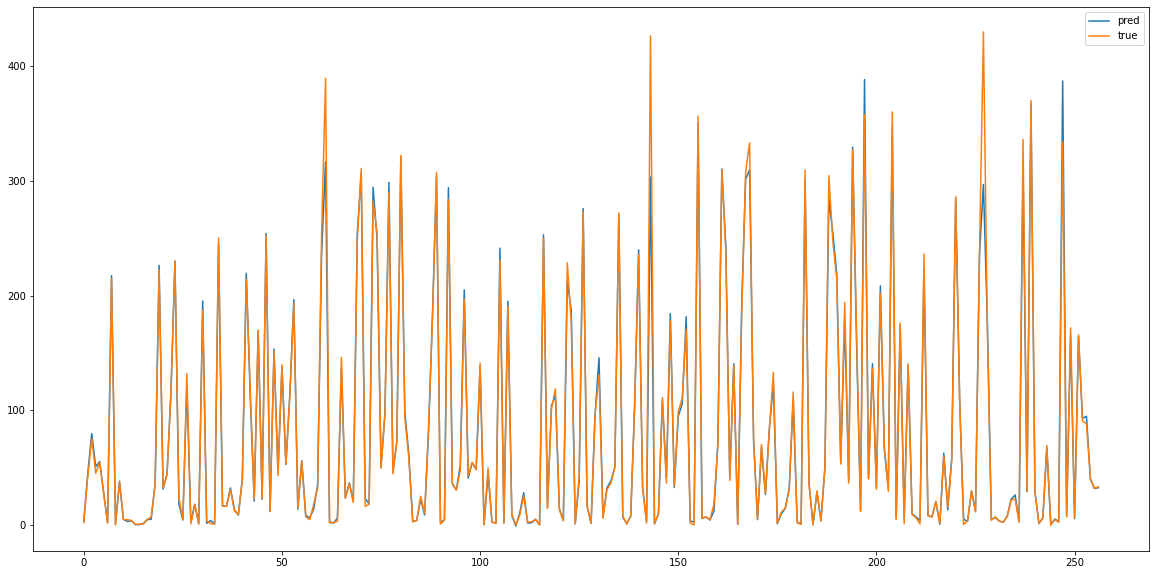

In [325]:
CATmodel = CatBoostRegressor(verbose=1, n_estimators=5000,  eval_metric='MAE')
CATmodel.fit(train_x, train_y, eval_set=[(val_x, val_y)],
                   use_best_model=True)

val_pred = CATmodel.predict(val_x)
plt.figure(figsize=(20,10))
plt.plot(np.array(val_pred),label = "pred")
plt.plot(np.array(val_y),label = "true")
plt.legend()
plt.show()

# mae
# print("MAE: ",mean_absolute_error(val_y, val_pred))

In [326]:
CATresult = CATmodel.predict(test_col)

submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = CATresult
submission.to_csv('./CATsubmit.csv', index=False)

[LightGBM] [Warning] early_stopping_round is set=1000, early_stopping_rounds=1000 will be ignored. Current value: early_stopping_round=1000
[1]	valid_0's l1: 84.0299	valid_0's l2: 11079.1
[2]	valid_0's l1: 83.6102	valid_0's l2: 10968.7
[3]	valid_0's l1: 83.1926	valid_0's l2: 10859.3
[4]	valid_0's l1: 82.7765	valid_0's l2: 10751.1
[5]	valid_0's l1: 82.3625	valid_0's l2: 10643.9
[6]	valid_0's l1: 81.9505	valid_0's l2: 10537.8
[7]	valid_0's l1: 81.541	valid_0's l2: 10432.7
[8]	valid_0's l1: 81.1331	valid_0's l2: 10328.7
[9]	valid_0's l1: 80.7267	valid_0's l2: 10225.7
[10]	valid_0's l1: 80.3243	valid_0's l2: 10124.5
[11]	valid_0's l1: 79.9219	valid_0's l2: 10023.5
[12]	valid_0's l1: 79.5251	valid_0's l2: 9924.45
[13]	valid_0's l1: 79.1263	valid_0's l2: 9825.5
[14]	valid_0's l1: 78.7292	valid_0's l2: 9727.54
[15]	valid_0's l1: 78.3377	valid_0's l2: 9631.36
[16]	valid_0's l1: 77.945	valid_0's l2: 9535.32
[17]	valid_0's l1: 77.5548	valid_0's l2: 9440.23
[18]	valid_0's l1: 77.1657	valid_0's l2

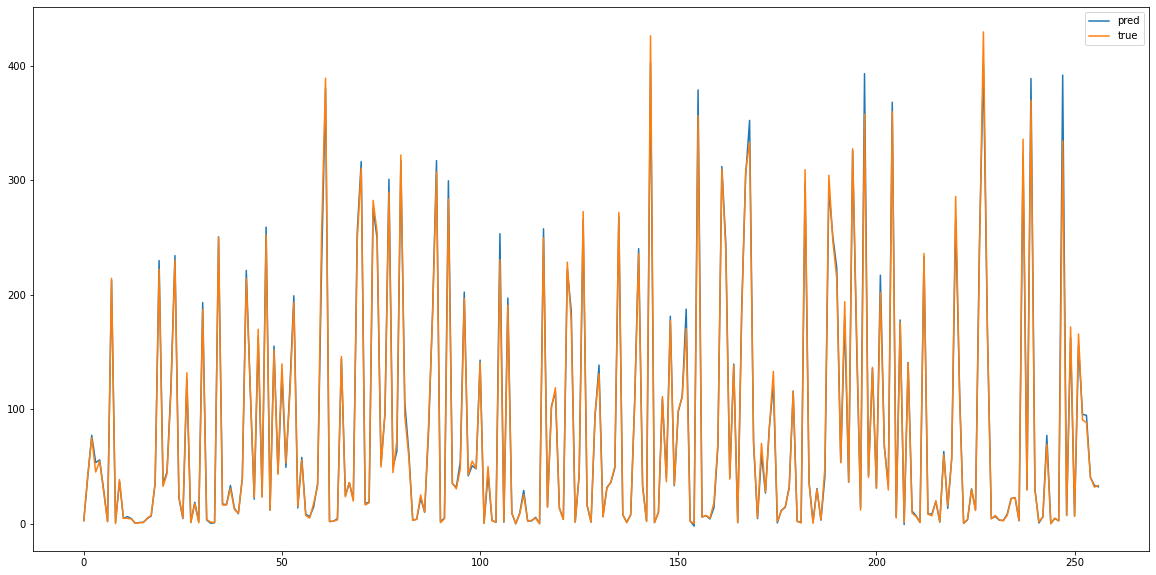

In [327]:
LGBMmodel = lgb.LGBMRegressor(objective= "regression", boosting_type='gbdt', random_state = 32, n_estimators=50000, learning_rate= 0.005,  early_stopping_rounds=1000)
LGBMmodel.fit(train_x, train_y, eval_set = [(val_x, val_y)], eval_metric='l1')

val_pred = LGBMmodel.predict(val_x)
plt.figure(figsize=(20,10))
plt.plot(np.array(val_pred),label = "pred")
plt.plot(np.array(val_y),label = "true")
plt.legend()
plt.show()

In [328]:
LGBMresult = LGBMmodel.predict(test_col)

submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = LGBMresult
submission.to_csv('./LGBMsubmit.csv', index=False)

In [329]:
def scale_datasets(x_train, x_test):
  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled

train_scaled, test_scaled = scale_datasets(train_col, test_col)

train_x, val_x, train_y, val_y = train_test_split(train_scaled, train_target, test_size=0.2, random_state=32)

Epoch 1/1000
32/32 [==============================] - 1s 7ms/step - loss: 79.4518 - mean_absolute_error: 79.4518 - val_loss: 84.4693 - val_mean_absolute_error: 78.9123
Epoch 2/1000
32/32 [==============================] - 0s 3ms/step - loss: 77.8863 - mean_absolute_error: 77.8863 - val_loss: 80.9053 - val_mean_absolute_error: 75.0324
Epoch 3/1000
32/32 [==============================] - 0s 4ms/step - loss: 70.9920 - mean_absolute_error: 70.9920 - val_loss: 69.9437 - val_mean_absolute_error: 62.6538
Epoch 4/1000
32/32 [==============================] - 0s 4ms/step - loss: 57.7646 - mean_absolute_error: 57.7646 - val_loss: 53.0221 - val_mean_absolute_error: 49.1583
Epoch 5/1000
32/32 [==============================] - 0s 4ms/step - loss: 42.8525 - mean_absolute_error: 42.8525 - val_loss: 38.0790 - val_mean_absolute_error: 34.1352
Epoch 6/1000
32/32 [==============================] - 0s 4ms/step - loss: 30.5218 - mean_absolute_error: 30.5218 - val_loss: 24.0447 - val_mean_absolute_error: 

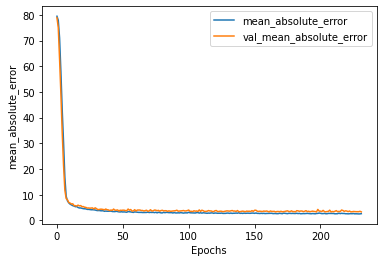

In [331]:
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(100, kernel_initializer='normal', activation='relu'),
    Dense(50, kernel_initializer='normal', activation='relu'),
    Dense(25, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
ANNmodel = build_model_using_sequential()

# loss function
mae = MeanAbsoluteError()
ANNmodel.compile(
    loss=mae, 
    optimizer=Adam(learning_rate=0.001), 
    metrics=[mae]
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=70,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# train the model
history = ANNmodel.fit(
    train_x, 
    train_y, 
    epochs=1000, 
    batch_size=32,
    validation_data=(val_x, val_y),
    callbacks=[early_stopping_monitor]
)


def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_absolute_error')

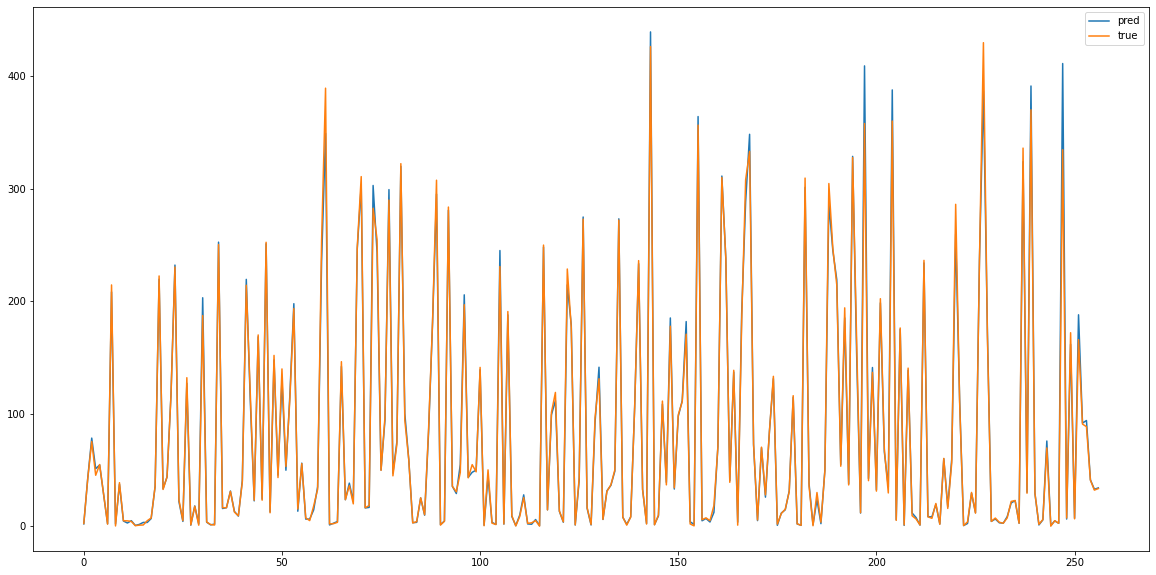

In [332]:
val_pred = ANNmodel.predict(val_x)
plt.figure(figsize=(20,10))
plt.plot(np.array(val_pred),label = "pred")
plt.plot(np.array(val_y),label = "true")
plt.legend()
plt.show()

In [333]:
ANNresult = ANNmodel.predict(test_scaled)

submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = ANNresult
submission.to_csv('./ANNsubmit.csv', index=False)

In [191]:
CNN = pd.read_csv('./CNNsubmit.csv')
CAT = pd.read_csv('./CATsubmit.csv')
LGBM = pd.read_csv('./LGBMsubmit.csv')
ANN = pd.read_csv('./ANNsubmit.csv')

submission_final = pd.read_csv('./sample_submission.csv')
submission_final['leaf_weight'] = (CNN['leaf_weight'] * 0.25 + CAT['leaf_weight'] * 0.25 + LGBM['leaf_weight'] * 0.25 + ANN['leaf_weight'] * 0.25)
submission_final.to_csv('FINALsubmit', index=False)